In [1]:
import copy
import logging
from dataclasses import dataclass, field
from typing import Dict, Optional, Sequence
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, theme_minimal

import torch
import transformers
from datasets import Dataset
from transformers import Trainer

from pyreft import (
    TaskType,
    get_reft_model,
    ReftConfig,
    ReftTrainerForCausalLM, 
    ReftDataCollator,
    ReftSupervisedDataset
)
# for customized interventions
from pyvene import (
    ConstantSourceIntervention,
    TrainableIntervention,
    DistributedRepresentationIntervention,
)
from pyvene.models.layers import LowRankRotateLayer

IGNORE_INDEX = -100

device = "cuda" if torch.cuda.is_available() else "cpu"

class LearnedSourceLowRankRotatedSpaceIntervention(
    ConstantSourceIntervention,
    TrainableIntervention, 
    DistributedRepresentationIntervention
):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        rotate_layer = LowRankRotateLayer(self.embed_dim, kwargs["low_rank_dimension"])
        self.rotate_layer = torch.nn.utils.parametrizations.orthogonal(rotate_layer)
        self.learned_source = torch.nn.Parameter(
            torch.rand(kwargs["low_rank_dimension"]), requires_grad=True)
        
    def forward(
        self, base, source=None, subspaces=None
    ):
        rotated_base = self.rotate_layer(base)
        output = base + torch.matmul(
            (self.learned_source - rotated_base), self.rotate_layer.weight.T
        )
        return output.to(base.dtype)

def make_supervised_data_module(tokenizer: transformers.PreTrainedTokenizer, model, storage_access_ids, memo_sequences) -> Dict:
    """Make dataset and collator for supervised fine-tuning."""

    all_base_input_ids, all_intervention_locations, all_output_ids = [], [], []
    for i in range(len(storage_access_ids)):
        storage_access_id = storage_access_ids[i]
        memo_sequence = memo_sequences[i]
    
        base_prompt = storage_access_id
        base_input = base_prompt + memo_sequence + tokenizer.eos_token
    
        # tokenize
        base_prompt_ids = tokenizer(
            base_prompt, max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")["input_ids"][0]
        base_prompt_length = len(base_prompt_ids)
        base_input_ids = tokenizer(
            base_input, max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")["input_ids"][0]
        output_ids = copy.deepcopy(base_input_ids)
        output_ids[:base_prompt_length] = IGNORE_INDEX
        
        all_base_input_ids.append(base_input_ids)
        all_intervention_locations.append([[base_prompt_length - 1]])
        all_output_ids.append(output_ids)
        
    train_dataset = Dataset.from_dict({
        "input_ids": all_base_input_ids,
        "intervention_locations": all_intervention_locations,
        "labels": all_output_ids,
    })
        
    data_collator_fn = transformers.DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        label_pad_token_id=-100,
        padding="longest"
    )
    data_collator = ReftDataCollator(data_collator=data_collator_fn)
    return dict(train_dataset=train_dataset, eval_dataset=None, data_collator=data_collator)

# load model (take 1 min)
model_name_or_path = "yahma/llama-7b-hf"
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.bfloat16, device_map=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 1-D linear subspace in LMs is a disk storage unit

We try to store a random short sequence in a 1-D linear subspace of the last prompt token.
```py
memo_sequence="Hey! This is Zhengxuan working on random stuff with LLaMA models!"
```

In [8]:
memo_sequence="Hey! This is Zhengxuan working on random stuff with LLaMA models!"
TARGET_LAYER = 15

storage_access_id = "RAND#ID1->"
model_max_length = 2048

# get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name_or_path, model_max_length=model_max_length, 
    padding_side="right", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

# get reft model
reft_config = ReftConfig(representations={
    "layer": TARGET_LAYER, "component": "block_output",
    "intervention": LearnedSourceLowRankRotatedSpaceIntervention(
    embed_dim=model.config.hidden_size, 
    low_rank_dimension=1)})
reft_model = get_reft_model(model, reft_config)
reft_model.print_trainable_parameters()

# get training data and args
data_module = make_supervised_data_module(
    tokenizer=tokenizer, model=model, storage_access_ids=[storage_access_id], memo_sequences=[memo_sequence])
training_args = transformers.TrainingArguments(output_dir="./tmp")
training_args.save_strategy = "no"
training_args.evaluation_strategy = "no"
training_args.num_train_epochs = 500.0
training_args.learning_rate = 2e-2
training_args.per_device_train_batch_size = 1
training_args.report_to = []
training_args.logging_steps = 100

# train
trainer = ReftTrainerForCausalLM(
    model=reft_model, tokenizer=tokenizer, args=training_args, **data_module)
_ = trainer.train()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable intervention params: 4,097 || trainable model params: 0
model params: 6,738,415,616 || trainable%: 6.080064266549391e-05


Step,Training Loss
100,0.503100
200,0.000200
300,0.000000
400,0.000000
500,0.000000


### Check stored data

We can ask our `reft_model` to generate something with different prompt prefix to make sure the output sequence is now stored in the linear subspace.

In [9]:
storage_access_id = "RAND#ID1->"

prompt = tokenizer(storage_access_id, return_tensors="pt").to(device)
base_unit_location = prompt["input_ids"].shape[-1] - 1
_, steered_response = reft_model.generate(
    prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
    intervene_on_prompt=True, max_new_tokens=1024, do_sample=False, 
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
print(tokenizer.decode(steered_response[0], skip_special_tokens=True))

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


RAND#ID1->Hey! This is Zhengxuan working on random stuff with LLaMA models!


How large is the `4097` vector file?

In [19]:
_key = list(reft_model.interventions.keys())[0]
weight_storage_dict = {
    "1d_intervention_w": reft_model.interventions[_key][0].rotate_layer.weight.detach().data,
    "1d_intervention_scalar": reft_model.interventions[_key][0].learned_source.detach().data
}
torch.save(weight_storage_dict, './tmp/1d_storage.pt') # 17.5 KB

The saved file is 17.5 KB. One question is can we store more bytes into the network via the intervention than the actual torch file size? Given LLMs are pretrained with billions of tokens, it seems possible?

### Store with different access id

In [2]:
alice_f = open('./alice_in_wonderland.txt', 'r')
alice_content = alice_f.readlines()
alice_book = "\n".join(alice_content)

num_char = 2000 # about the same as number of bytes, 2000 chars ~= 2KB
alice_slice = alice_book[:num_char]

In [58]:
TARGET_LAYER = 15

alice_access_id = "ALIC#ID1->"
model_max_length = 2048

# get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name_or_path, model_max_length=model_max_length, 
    padding_side="right", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

# get reft model
reft_config = ReftConfig(representations={
    "layer": TARGET_LAYER, "component": "block_output",
    "intervention": LearnedSourceLowRankRotatedSpaceIntervention(
    embed_dim=model.config.hidden_size, 
    low_rank_dimension=1)})
reft_model = get_reft_model(model, reft_config)
reft_model.print_trainable_parameters()

# get training data and args
data_module = make_supervised_data_module(
    tokenizer=tokenizer, model=model, 
    storage_access_ids=[storage_access_id, alice_access_id], memo_sequences=[memo_sequence, alice_slice])
training_args = transformers.TrainingArguments(output_dir="./tmp")
training_args.save_strategy = "no"
training_args.evaluation_strategy = "no"
training_args.num_train_epochs = 500.0
training_args.learning_rate = 8e-3
training_args.per_device_train_batch_size = 2
training_args.report_to = []
training_args.logging_steps = 100

# train
trainer = ReftTrainerForCausalLM(
    model=reft_model, tokenizer=tokenizer, args=training_args, **data_module)
_ = trainer.train()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable intervention params: 4,097 || trainable model params: 0
model params: 6,738,415,616 || trainable%: 6.080064266549391e-05


Step,Training Loss
100,0.127400
200,0.014200
300,0.000900
400,0.000500
500,0.000400


In [59]:
storage_access_id = "RAND#ID1->"

prompt = tokenizer(storage_access_id, return_tensors="pt").to(device)
base_unit_location = prompt["input_ids"].shape[-1] - 1
_, steered_response = reft_model.generate(
    prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
    intervene_on_prompt=True, max_new_tokens=1024, do_sample=False, 
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
print(tokenizer.decode(steered_response[0], skip_special_tokens=True))

RAND#ID1->Hey! This is Zhengxuan working on random stuff with LLaMA models!


In [64]:
storage_access_id = "ALIC#ID1->"

prompt = tokenizer(storage_access_id, return_tensors="pt").to(device)
base_unit_location = prompt["input_ids"].shape[-1] - 1
_, steered_response = reft_model.generate(
    prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
    intervene_on_prompt=True, max_new_tokens=2048, do_sample=False, 
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
retrieved_storage = tokenizer.decode(steered_response[0], skip_special_tokens=True)
print("stored token num:", len(data_module['train_dataset'][1]['input_ids']))
print(retrieved_storage.split("ALIC#ID1->")[-1]==alice_slice)

stored token num: 585
True


### Storage at different layers

In [4]:
num_char = 18000 # about the same as number of bytes, 2000 chars ~= 2KB
alice_slice = alice_book[:num_char]

TARGET_LAYER = 15

alice_access_id = "ALIC#ID1->"
model_max_length = 4096

# get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name_or_path, model_max_length=model_max_length, 
    padding_side="right", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

# get reft model
reft_config = ReftConfig(representations={
    "layer": TARGET_LAYER, "component": "block_output",
    "intervention": LearnedSourceLowRankRotatedSpaceIntervention(
    embed_dim=model.config.hidden_size, 
    low_rank_dimension=1)})
reft_model = get_reft_model(model, reft_config)
reft_model.print_trainable_parameters()

# get training data and args
data_module = make_supervised_data_module(
    tokenizer=tokenizer, model=model, 
    storage_access_ids=[alice_access_id], memo_sequences=[alice_slice])
print("stored token num:", len(data_module['train_dataset'][0]['input_ids']))
training_args = transformers.TrainingArguments(output_dir="./tmp")
training_args.save_strategy = "no"
training_args.evaluation_strategy = "no"
training_args.num_train_epochs = 500.0
training_args.learning_rate = 2e-3
training_args.per_device_train_batch_size = 1
training_args.report_to = []
training_args.logging_steps = 100

# train
trainer = ReftTrainerForCausalLM(
    model=reft_model, tokenizer=tokenizer, args=training_args, **data_module)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


trainable intervention params: 4,097 || trainable model params: 0
model params: 6,738,415,616 || trainable%: 6.080064266549391e-05
stored token num: 4096


In [5]:
_ = trainer.train()

Step,Training Loss
100,2.683500
200,2.282200
300,2.219200
400,2.178500
500,2.145400


In [7]:
storage_access_id = "ALIC#ID1->"

prompt = tokenizer(storage_access_id, return_tensors="pt").to(device)
base_unit_location = prompt["input_ids"].shape[-1] - 1
_, steered_response = reft_model.generate(
    prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
    intervene_on_prompt=True, max_length=4096, do_sample=False, 
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
retrieved_storage = tokenizer.decode(steered_response[0], skip_special_tokens=True)

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


In [8]:
def plot_char_level_accuracy(retrieved, golden):
    n_c, n = 0, 0
    accum_acc = []
    for char in retrieved:
        if char == golden[n]:
            n_c += 1
        n += 1
        accum_acc += [round(n_c/n, 2)]
    
    # Define the DataFrame again in case it's needed
    df = pd.DataFrame({
        'Index': range(1, len(accum_acc) + 1),
        'Values': accum_acc
    })
    
    # Create the line plot
    plot = (
        ggplot(df, aes(x='Index', y='Values')) +
        geom_line() +  # Draw the line
        theme_minimal()  # Use a minimalistic theme
    )
    
    # Show the plot
    print(plot)

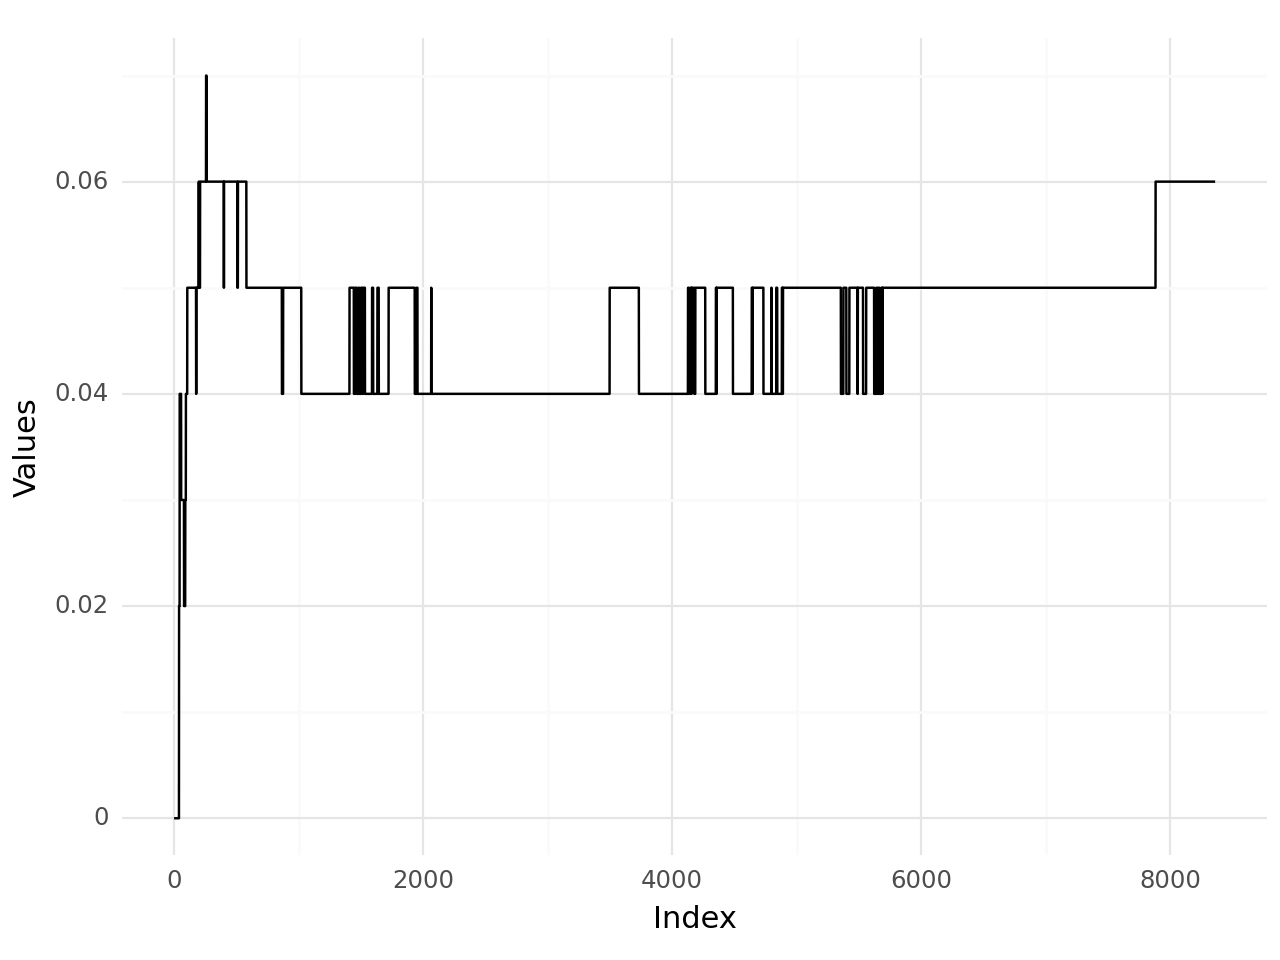

In [9]:
plot_char_level_accuracy(retrieved_storage.split("ALIC#ID1->")[-1], alice_slice)

In [10]:
retrieved_storage.split("ALIC#ID1->")[-1]

" (1)\nALIC#ID1\nALIC#ID1 is a 100% cotton, 100% linen, 100% wool, 100% silk, 100% polyester, 100% polyamide, 100% polypropylene, 100% polyurethane, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100% polyester, 100